## The Context
In a previous [post](https://cgcooke.github.io/Blog/ar/computer%20vision/blender/visualisation/2021/02/17/An-Introduction-To-Augemented-Reality.html), I showed how we could use an ArUco tag to find the position and orientation of a camera. This was done using the four exterior points on the tag. If we can detect more points on the tag, we could potentially position the camera more accurately with respect to the tag.

At a high level, what we can do is:
1. Detect the exterior corners of the tag
2. Compute the homography (relationship) between the tag and its image
3. Detect points in the image
4. Transform them using the homography
5. Detect points in the tag
6. Match the transformed points from the image with points in the tag
7. Use all of the points to position the camera


As always, let's start by importing what we need.

In [1]:
import numpy as np
import cv2
import cv2.aruco as aruco
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as Rot
import glob
from sklearn.neighbors import KDTree

plt.rcParams['figure.figsize'] = [20,20]

I've already calibrated the camera, which means that we have both the camera matrix (K) and the distortion parameters for the camera.

In [2]:
K = np.array([[3286.9, 0.0 , 2032.8],
              [0.0   , 3282.3, 1519.1],
              [0.0   , 0.0   ,    1.0]])

dist = np.array([[2.44663616e-01],[-1.48023303e+00],[2.04607109e-03],[1.53484564e-03],[2.56349651e+00]])

points_3d = np.array([[0.0,1.0,0.0],
                      [1.0,1.0,0.0],
                      [1.0,0.0,0.0],
                      [0.0,0.0,0.0]])

tag_size_pixels = 1_000

Now we need to configure our ArUco code detector. 

Firstly, specify that it should be looking for a "4X4_50" type tag. 


In [3]:
arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)

Secondly, we tell it that we want to configure the detector; in particular, we want to find the corners to a very high degree of accuracy (Sub-Pixel).

In [4]:
arucoParams = cv2.aruco.DetectorParameters_create()
arucoParams.cornerRefinementMethod = aruco.CORNER_REFINE_SUBPIX
arucoParams.cornerRefinementWinSize = 25

### Detect the exterior corners of the tag
Now let's extract the exterior points of the tag.

In [5]:
fname = 'data/2021-02-24-Positioning-Using-ArUco-Tags/ArUco.jpg'
img = cv2.imread(fname)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

(aruco_tag_corners, ids, rejected) = cv2.aruco.detectMarkers(gray, arucoDict, parameters=arucoParams)

aruco_tag_corners = np.array(aruco_tag_corners).squeeze()

### Compute the homography
Now let's find the homography/relationship between the tag and the image.

In [6]:
def find_homography(corners,tag_size_pixels):
    src_pts = corners
    dst_pts = np.array([[0, tag_size_pixels], [tag_size_pixels, tag_size_pixels],
                        [tag_size_pixels, 0], [0, 0]])
    
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    return(M)

tag_index = 0
tag_number = int(ids[tag_index])

In [7]:
M = find_homography(aruco_tag_corners[tag_index,:,:], tag_size_pixels)

### Detect points in the image
Now let's detect the points in the image and the tag.

In [8]:
def detect_features(image,max_num_features=200,threshold=0.01,min_distance=50):
    detected_corners = cv2.goodFeaturesToTrack(image,max_num_features,threshold,min_distance)
    winSize = (5, 5)
    zeroZone = (-1, -1)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TermCriteria_COUNT, 40, 0.001)
    # Calculate the refined corner locations
    detected_corners = cv2.cornerSubPix(image, detected_corners, winSize, zeroZone, criteria)
    return(detected_corners)

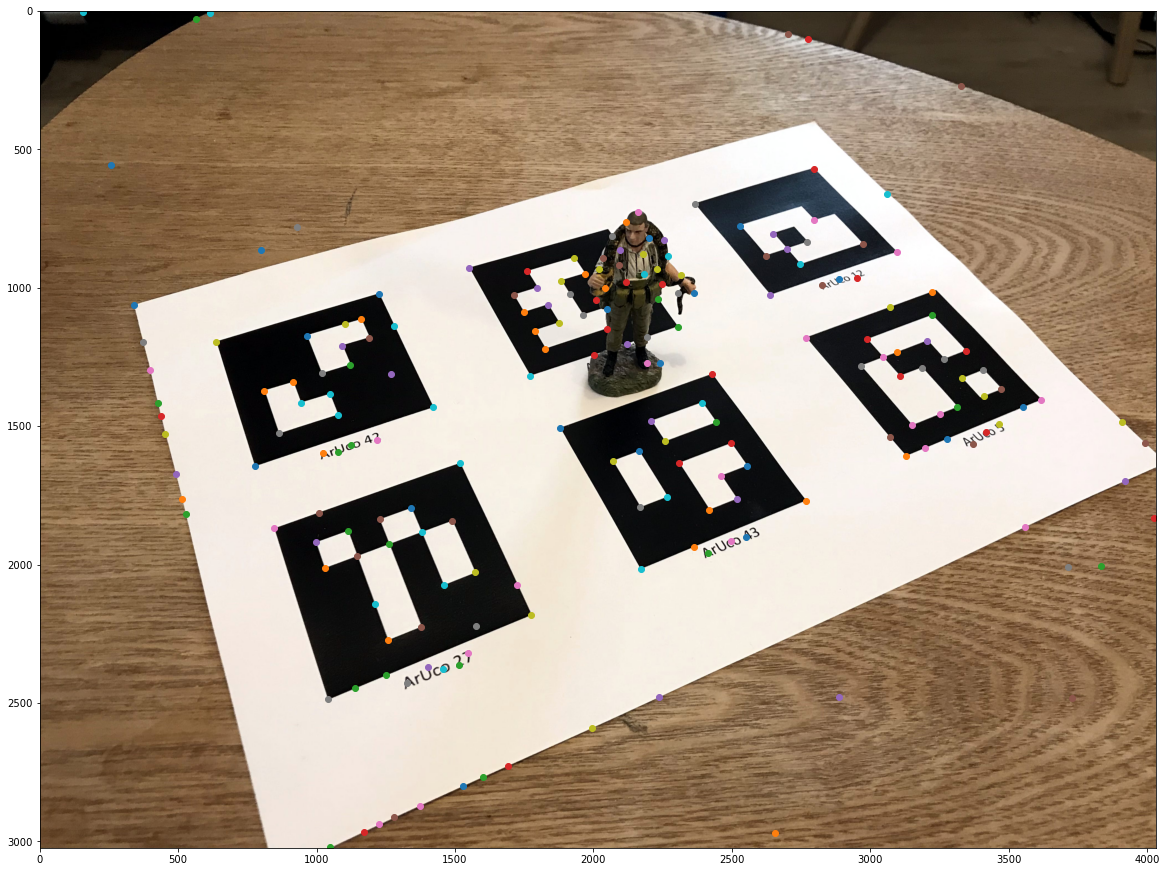

In [9]:
detected_features_image = detect_features(gray)
for i in detected_features_image:
    x,y = i.ravel()
    plt.scatter(x,y)
    
plt.imshow(img[:,:,::-1])
plt.show()

In [10]:
# load the ArUCo dictionary
def load_tag(tag_number, tag_size_pixels):
    arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
    tag = np.zeros((tag_size_pixels, tag_size_pixels, 1), dtype="uint8")
    cv2.aruco.drawMarker(arucoDict, tag_number, tag_size_pixels, tag, 1);
    tag = tag.squeeze();
    return(tag)

### Transform the points using the homography
Now let's transform the points detected in the image using the homography. This means that a point detected in the image should be in the same x,y position as the corresponding point in the tag after the transform.

In [11]:
detected_features_image_transformed = cv2.perspectiveTransform(detected_features_image, M)
detected_features_image_transformed[:,:,1] = tag_size_pixels - detected_features_image_transformed[:,:,1]

### Detect points in the tag

In [12]:
tag = load_tag(tag_number, tag_size_pixels)
detected_features_tag = detect_features(tag, max_num_features=200, threshold=0.1, min_distance=50)

Now let's visualise the extracted key points. I'm plotting the transformed points from the image in red and the features from the tag in blue.

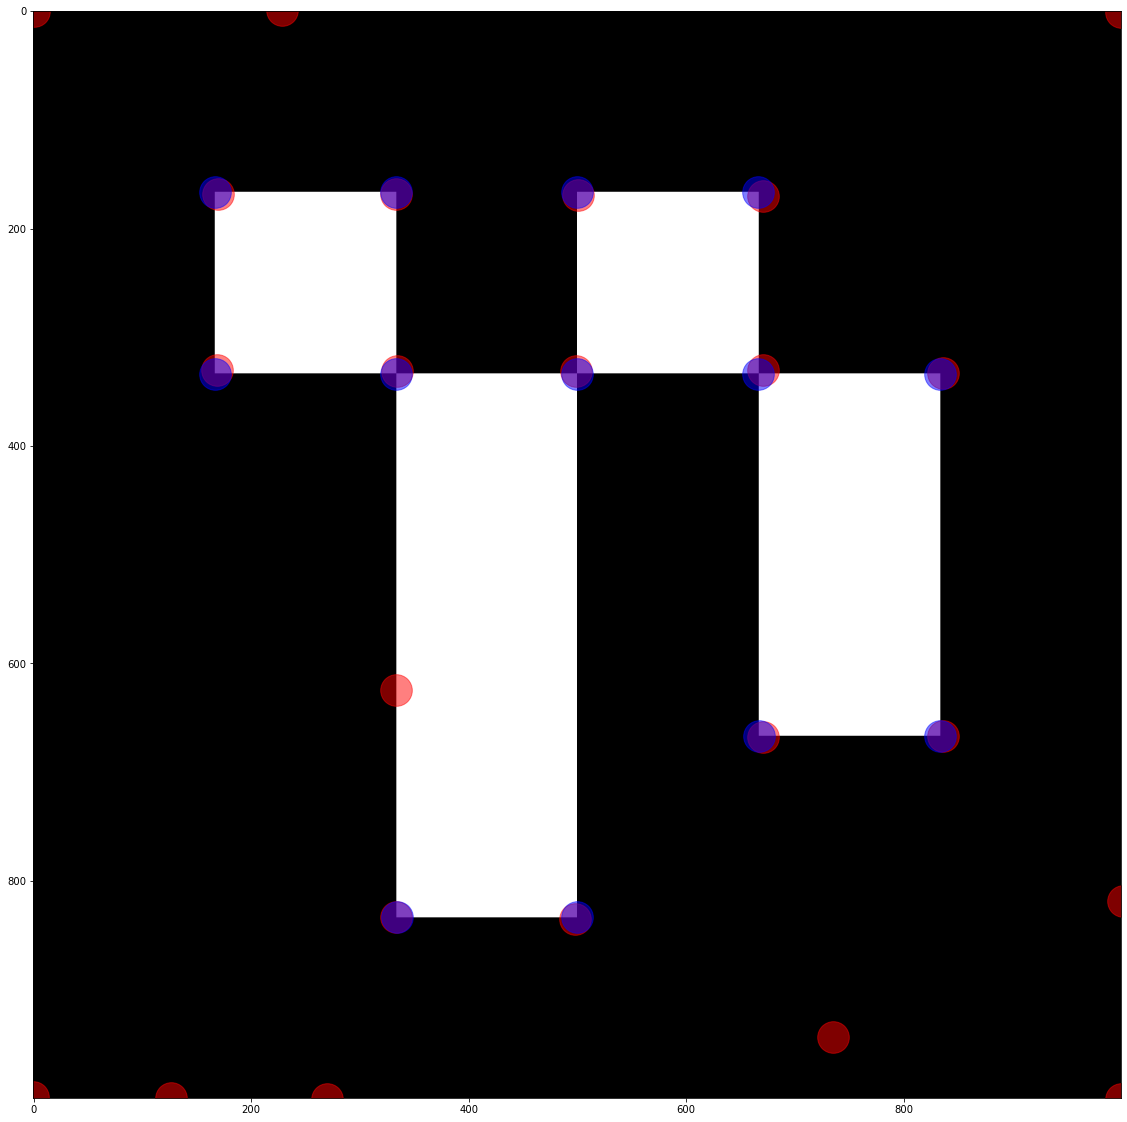

In [13]:
for feature in detected_features_image_transformed:
    x,y = feature.ravel()
    plt.scatter(x,y,color='r',alpha=0.5, s=1_000)
    
for feature in detected_features_tag:
    x,y = feature.ravel()
    plt.scatter(x,y,color='b',alpha=0.5, s=1_000)

plt.imshow(tag,cmap='gray')
plt.show()

In [14]:
detected_features_image_transformed[:,:,1] = tag_size_pixels - detected_features_image_transformed[:,:,1]
detected_features_tag[:,:,1] = tag_size_pixels - detected_features_tag[:,:,1]

### Match the transformed points from the image, with points in the tag

In [15]:
def match_features(detected_features_image_transformed, detected_features_tag):
    X = detected_features_image_transformed.squeeze()  # 10 points in 3 dimensions
    tree = KDTree(X, leaf_size=2)       

    detected_features_tag = detected_features_tag.squeeze()

    points_3d = []
    points_2d = []

    for i in range(detected_features_tag.shape[0]):
        dist, ind = tree.query(detected_features_tag[i].reshape((1,-1)), k=1)
        points_3d.append(detected_features_tag[i])
        points_2d.append(detected_features_image[int(ind)])
        
    points_3d = np.array(points_3d)
    points_2d = np.array(points_2d)
    points_2d = points_2d.squeeze()
    
    points_3d /= tag_size_pixels

    return(points_2d, points_3d)

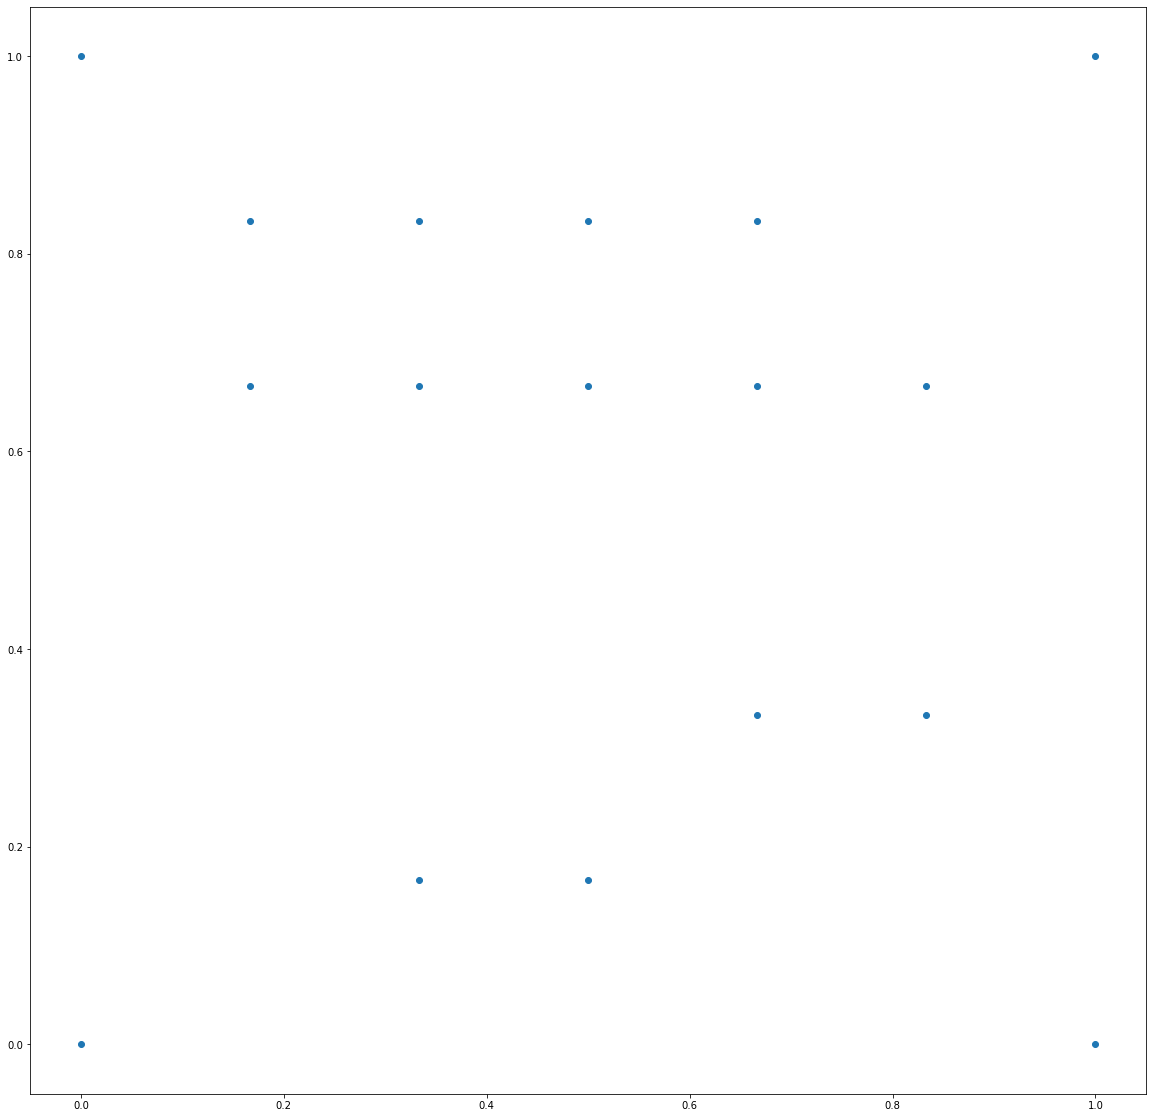

In [16]:
points_2d_interior, points_3d_interior =  match_features(detected_features_image_transformed, detected_features_tag)

points_3d_exterior = np.array([[0.0,1.0],
                              [1.0,1.0],
                              [1.0,0.0],
                              [0.0,0.0]])

points_2d_exterior = aruco_tag_corners[tag_index,:,:].squeeze()

points_3d = np.vstack([points_3d_exterior, points_3d_interior])
points_2d = np.vstack([points_2d_exterior, points_2d_interior])

points_3d = np.hstack([points_3d, np.zeros((points_3d.shape[0],1))])

plt.scatter(points_3d[:,0], points_3d[:,1])
plt.show()

### Use all of the points to position the camera

Instead of using all of the points, let's use RANSAC, an algorithm that can pick good inliers. 

In [17]:
ret, rvec, tvec, inliers = cv2.solvePnPRansac(objectPoints = points_3d,
                                              imagePoints = points_2d,
                                              cameraMatrix = K,
                                              distCoeffs = dist,
                                              reprojectionError = 5**2,
                                              iterationsCount=1_000)

Now let's find the camera centre with respect to the marker.

In [18]:
r = Rot.from_rotvec(rvec[:,0])
R = r.as_matrix()
t = np.array(tvec)
C = -np.dot(R.T,tvec)
print(C)

[[ 0.26481151]
 [-1.9600099 ]
 [ 4.03681725]]


Now, let's visualise the coordinates axes to do a quick sanity check.

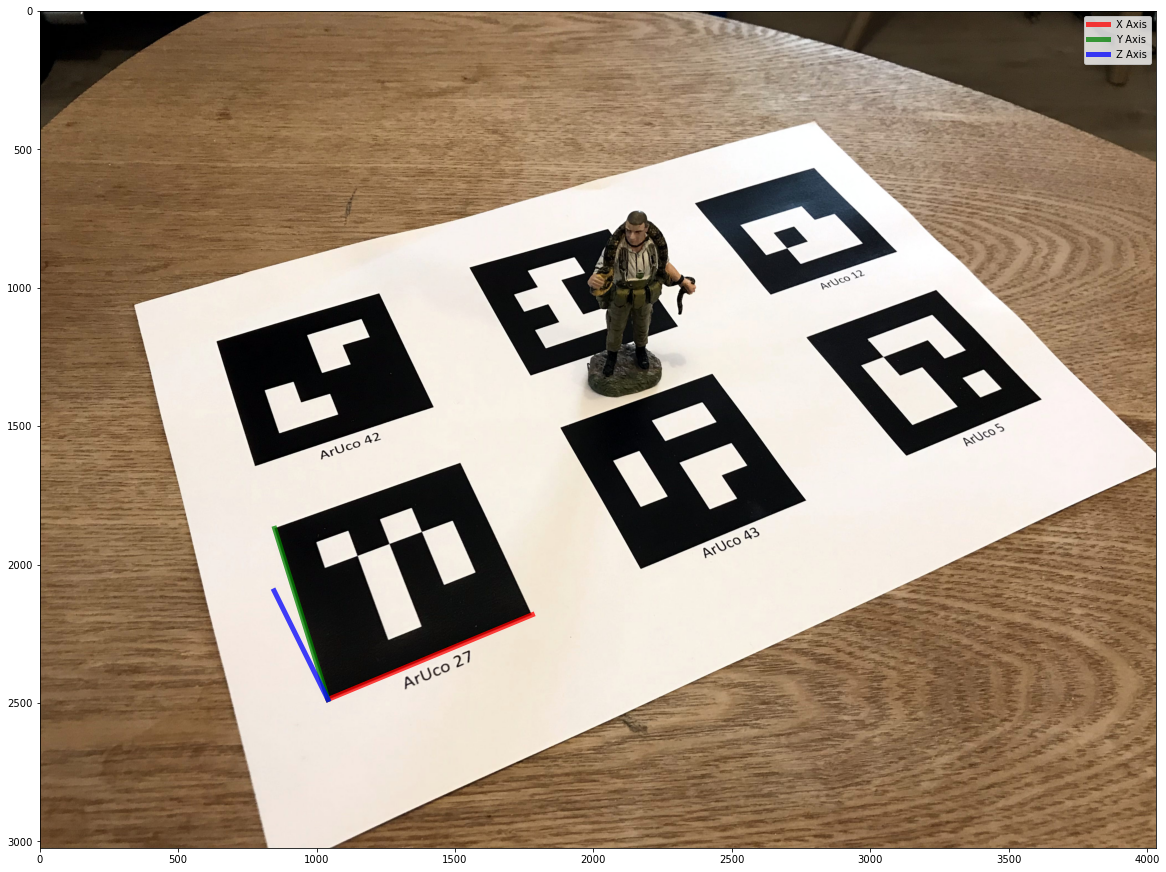

In [19]:
axis = np.float32([[1,0,0], [0,1,0], [0,0,1]]).reshape(-1,3)
imgpts, jac = cv2.projectPoints(axis, rvec, tvec, K, dist)
imgpts = np.squeeze(imgpts)

[cx,cy] = points_2d_exterior[3]

plt.imshow(img[:,:,::-1])
plt.plot([cx,imgpts[0,0]],[cy, imgpts[0,1]], color='r', alpha=0.75, linewidth=5, label='X Axis')
plt.plot([cx,imgpts[1,0]],[cy, imgpts[1,1]], color='g', alpha=0.75, linewidth=5, label='Y Axis')
plt.plot([cx,imgpts[2,0]],[cy, imgpts[2,1]], color='b', alpha=0.75, linewidth=5, label='Z Axis')
plt.legend()
plt.show()